In [1]:
#import necessary packages
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
def get_list_of_content(content):
    list_of_content = []
    
    for data in content:
        list_of_content.append(data.text.strip())
        
    return list_of_content

In [3]:
def get_dictionary_of_covid_stats(content):
    list_of_content = get_list_of_content(content)
    
    dictionary_of_covid_stats = {'Position': [], 'Country': [], 'Total Cases': [], 'Total Deaths': [], 'Total Recovered' : [],
                                 'Active Cases' : [], 'Serious / Critical Cases': [], 'Total Tests': [], 'population': []}
    
    for i, stat in enumerate(list_of_content):
        if i % 19 == 0:
            dictionary_of_covid_stats['Position'].append(stat)
        elif i % 19 == 1:
            dictionary_of_covid_stats['Country'].append(stat)
        elif i % 19 == 2:
            dictionary_of_covid_stats['Total Cases'].append(stat)
        elif i % 19 == 4:
            dictionary_of_covid_stats['Total Deaths'].append(stat)
        elif i % 19 == 6:
            dictionary_of_covid_stats['Total Recovered'].append(stat)
        elif i % 19 == 8:
            dictionary_of_covid_stats['Active Cases'].append(stat)
        elif i % 19 == 9:
            dictionary_of_covid_stats['Serious / Critical Cases'].append(stat)
        elif i % 19 == 12:
            dictionary_of_covid_stats['Total Tests'].append(stat)
        elif i % 19 == 14:
            dictionary_of_covid_stats['population'].append(stat)
    
    return dictionary_of_covid_stats

In [4]:
def parse_dataframe_values(string):
    li = string.split(',')
    num = ''
    for l in li:
        num += l
    try:
        return int(num)
    except ValueError:
        if len(num) > 0:
            if num == 'N/A':
                return pd.NA
            return num
        else:
            return pd.NA

In [5]:
def request_worldometer_table():
    """
    Function to send request to get worldometer coronavirus table page
    """
    url = 'https://www.worldometers.info/coronavirus/'
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        print('Error Connecting:', e.args)
        return None
    except requests.exceptions.RequestException as e:
        print('Error Connecting:', e.args)
        return None
    else:
        soup = BeautifulSoup(response.text, 'lxml')
        table = soup.find(id='main_table_countries_today')
        content = table.find_all('td')
        
        dictionary_of_covid_stats = get_dictionary_of_covid_stats(content)
        dataframe = pd.DataFrame(dictionary_of_covid_stats)
        indexes_to_drop = dataframe[dataframe['Position'] == ''].index
        dataframe.drop(indexes_to_drop, inplace=True)
        for i in dataframe.columns:
            dataframe[i] = dataframe[i].apply(parse_dataframe_values)
        
        return json.loads(dataframe.to_json(orient="records"))

In [6]:
worldometer_json = request_worldometer_table()

In [7]:
def get_detailed_table():
    table = worldometer_json
    corona_virus_detailed_table = pd.DataFrame(table)
    corona_virus_detailed_table.sort_values(by='Total Cases', ascending=False, inplace=True)
    corona_virus_detailed_table.index = range(1, len(corona_virus_detailed_table) + 1)
    return corona_virus_detailed_table

get_detailed_table()

,Position,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
1,1,USA,2356715,122248.0,980367.0,1254100.0,16477.0,28492770.0,3.309546e+08
2,2,Brazil,1086990,50659.0,579226.0,457105.0,8318.0,2430347.0,2.125211e+08
3,3,Russia,592280,8206.0,344416.0,239658.0,2300.0,17200000.0,1.459331e+08
4,4,India,426910,13703.0,237252.0,175955.0,8944.0,6950493.0,1.379641e+09
5,5,UK,304331,42632.0,NaN,NaN,379.0,7890145.0,6.787730e+07
...,...,...,...,...,...,...,...,...,...
211,210,Papua New Guinea,8,NaN,8.0,0.0,NaN,5281.0,8.941675e+06
212,211,Caribbean Netherlands,7,NaN,7.0,0.0,NaN,424.0,2.621700e+04
213,212,St. Barth,6,NaN,6.0,0.0,NaN,152.0,9.876000e+03
214,213,Anguilla,3,NaN,3.0,0.0,NaN,93.0,1.499900e+04


In [8]:
get_detailed_table().dtypes

Position                      int64
Country                      object
Total Cases                   int64
Total Deaths                float64
Total Recovered             float64
Active Cases                float64
Serious / Critical Cases    float64
Total Tests                 float64
population                  float64
dtype: object

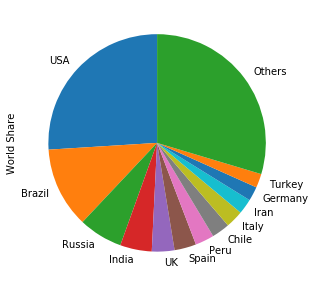

In [9]:
def get_share():
    columns = ['Country', 'Total Cases']
    corona_virus_detailed_table = get_detailed_table()
    countries_world_share = pd.DataFrame(corona_virus_detailed_table, columns = columns)
    countries_world_share['World Share'] = countries_world_share['Total Cases'] / sum(countries_world_share['Total Cases']) * 100
    more_than_2 = countries_world_share[countries_world_share['World Share'] >= 2]
    less_than_2 = countries_world_share[countries_world_share['World Share'] < 2]
    others = pd.DataFrame({'Country' : 'Others', 'Total Cases' : less_than_2['Total Cases'].sum(), 
                           'World Share': less_than_2['World Share'].sum()}, index=[len(more_than_2) + 1])

    world_share_aggregate = pd.concat([more_than_2, others], axis=0)
    return world_share_aggregate.set_index('Country')

get_share().plot.pie(y='World Share', figsize=(5,5), startangle=90, legend=False)

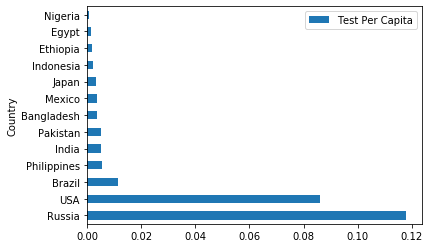

In [10]:
def get_tests_per_capita_table(start=0, stop=15, population_floor=0):
    corona_virus_detailed_table = get_detailed_table()
    tests_per_capita_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country','Total Tests', 'population'])
    tests_per_capita_table = tests_per_capita_table.dropna()
    tests_per_capita_table['Test Per Capita'] = tests_per_capita_table['Total Tests']/tests_per_capita_table['population']
    tests_per_capita_table.sort_values(by='Test Per Capita', ascending=False, inplace=True)
    tests_per_capita_table.index = range(1, len(tests_per_capita_table) + 1)
    if population_floor == 0:
        return tests_per_capita_table[start : stop]
    elif population_floor == 10000000:
        tpct_over_ten_million = tests_per_capita_table[tests_per_capita_table['population'] >= 10000000]
        tpct_over_ten_million.index = range(1, len(tpct_over_ten_million) + 1)
        return tpct_over_ten_million[start : stop]
    elif population_floor == 100000000:
        tpct_over_hundred_million = tests_per_capita_table[tests_per_capita_table['population'] >= 100000000]
        tpct_over_hundred_million.index = range(1, len(tpct_over_hundred_million) + 1)
        return tpct_over_hundred_million[start : stop]

get_tests_per_capita_table(population_floor=100000000).plot.barh(x='Country', y='Test Per Capita');

In [11]:
def get_death_rate(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    death_rate = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Deaths'])
    death_rate['Death Rate'] = (death_rate['Total Deaths'] / death_rate['Total Cases']) * 100
    death_rate.sort_values(by='Death Rate', ascending=False, inplace=True)
    death_rate = death_rate[death_rate['Total Cases'] >= 1000]
    death_rate.index = range(1, len(death_rate) + 1)
    return death_rate[start:stop]

get_death_rate()

,Country,Total Cases,Total Deaths,Death Rate
1,France,160377,29640.0,18.481453
2,Belgium,60550,9696.0,16.013212
3,Italy,238499,34634.0,14.521654
4,UK,304331,42632.0,14.008432
5,Hungary,4102,572.0,13.944417
6,Netherlands,49593,6090.0,12.279959
7,Mexico,180545,21825.0,12.088399
8,Spain,293352,28323.0,9.654954
9,Sweden,56043,5053.0,9.016291
10,Ecuador,50640,4223.0,8.339258


In [12]:
def get_recovered(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    percentage_recovered = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Recovered'])
    percentage_recovered = percentage_recovered.dropna()
    percentage_recovered = percentage_recovered.infer_objects()
    percentage_recovered['Percentage Recovered'] = (percentage_recovered['Total Recovered']/percentage_recovered['Total Cases']) * 100
    percentage_recovered.sort_values(by='Percentage Recovered', ascending=False, inplace=True)
    percentage_recovered.index = range(1, len(percentage_recovered) + 1)
    return percentage_recovered[start:stop]

get_recovered()

,Country,Total Cases,Total Recovered,Percentage Recovered
1,Saint Pierre Miquelon,1,1.0,100.0
2,Caribbean Netherlands,7,7.0,100.0
3,French Polynesia,60,60.0,100.0
4,Macao,45,45.0,100.0
5,Timor-Leste,24,24.0,100.0
6,Grenada,23,23.0,100.0
7,New Caledonia,21,21.0,100.0
8,Laos,19,19.0,100.0
9,Fiji,18,18.0,100.0
10,Saint Kitts and Nevis,15,15.0,100.0


In [13]:
def get_active_critical_table(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    active_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Active Cases', 'Serious / Critical Cases'])
#     active_table = active_table.dropna()
    active_table['% Active(of Total Cases)'] = (active_table['Active Cases']/active_table['Total Cases']) * 100
    active_table['% Critical(of active)'] = (active_table['Serious / Critical Cases']/active_table['Active Cases']) * 100
    active_table.dropna(inplace=True)
    active_table.index = range(1, len(active_table) + 1)
#     active_table = active_table[active_table['Country'] == 'Nigeria']
    return active_table[start:stop]
    
get_active_critical_table()

,Country,Total Cases,Active Cases,Serious / Critical Cases,% Active(of Total Cases),% Critical(of active)
1,USA,2356715,1254100.0,16477.0,53.213902,1.313851
2,Brazil,1086990,457105.0,8318.0,42.052365,1.819713
3,Russia,592280,239658.0,2300.0,40.463632,0.959701
4,India,426910,175955.0,8944.0,41.215947,5.083118
5,Peru,254936,104924.0,1143.0,41.156996,1.089360
6,Chile,242355,37307.0,1996.0,15.393534,5.350202
7,Italy,238499,20972.0,148.0,8.793328,0.705703
8,Iran,204952,31738.0,2887.0,15.485577,9.096351
9,Germany,191575,7713.0,376.0,4.026099,4.874887
10,Turkey,187685,22495.0,803.0,11.985508,3.569682


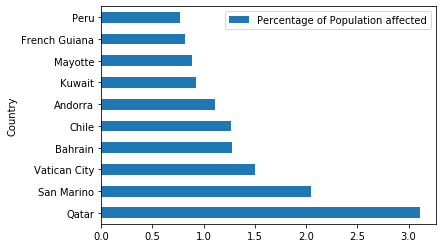

In [14]:
def get_percentage_affected(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    country_percentage_affected = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'population'])
    country_percentage_affected['Percentage of Population affected'] = (country_percentage_affected['Total Cases'] / country_percentage_affected['population'])*100
    country_percentage_affected.sort_values(by='Percentage of Population affected', ascending=False, inplace=True)
    country_percentage_affected.index = range(1, len(country_percentage_affected) + 1)
    return country_percentage_affected[start:stop]

get_percentage_affected().plot.barh(x='Country', y='Percentage of Population affected');

In [15]:
#trying to write tests for the functions
import unittest

class TestNotebook(unittest.TestCase):
    
    def test_get_countries_data_is_list(self):
        self.assertIsInstance(worldometer_json, list)
    
    def test_get_countries_data_contains_dict(self):
        self.assertIsInstance(worldometer_json[0], dict)
        
    def test_len_detailed_table_columns(self):
        self.assertEqual(len(get_detailed_table().columns), 9)
    
    def test_detailed_table_has_certain_countries(self):
        self.assertTrue('Nigeria' in list(get_detailed_table()['Country']))
        self.assertTrue('USA' in list(get_detailed_table()['Country']))
        self.assertTrue('UK' in list(get_detailed_table()['Country']))
        
    def test_get_share_table(self):
        self.assertGreater(get_share().loc['Others']['World Share'], 2)
        self.assertGreaterEqual(get_share().loc['USA']['World Share'], 2)
        
    def test_get_tests_per_capita_table(self):
        for test_per_capita in list(get_tests_per_capita_table()['Test Per Capita']):
            self.assertTrue(test_per_capita < 1)
        for over_ten_million in list(get_tests_per_capita_table(population_floor=10000000)['population']):
            self.assertTrue(over_ten_million >= 10000000)
        for over_hundred_million in list(get_tests_per_capita_table(population_floor=100000000)['population']):
            self.assertTrue(over_hundred_million >= 100000000)
            
    def test_get_death_rate(self):
        first_country = get_death_rate().loc[1]
        self.assertGreater(first_country['Total Cases'], first_country['Total Deaths'])
        
    def test_get_recovered(self):
        first_country = get_recovered().loc[1]
        self.assertLessEqual(first_country['Total Recovered'], first_country['Total Cases'])
    
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_detailed_table_has_certain_countries (__main__.TestNotebook) ... ok
test_get_countries_data_contains_dict (__main__.TestNotebook) ... ok
test_get_countries_data_is_list (__main__.TestNotebook) ... ok
test_get_death_rate (__main__.TestNotebook) ... ok
test_get_recovered (__main__.TestNotebook) ... ok
test_get_share_table (__main__.TestNotebook) ... ok
test_get_tests_per_capita_table (__main__.TestNotebook) ... ok
test_len_detailed_table_columns (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.145s

OK
